In [ ]:
!pip install icoscp --quiet
!pip install ipygee --quiet

     |████████████████████████████████| 3.3MB 8.0MB/s 
     |████████████████████████████████| 133kB 48.3MB/s 
     |████████████████████████████████| 71kB 6.0MB/s 
     |████████████████████████████████| 225kB 45.5MB/s 


In [ ]:
# python lib
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from tqdm import tqdm

# Import module:
import sys

# Set path to ICOS tools:
sys.path.insert(0,'/data/project/pytools')

# Import ICOS tools:
from icoscp.sparql import sparqls
#from icoscp.cpb.cpbinfile import CpBinFile 
from icoscp.cpb.dobj import Dobj # @Alex ?
from icoscp.sparql.runsparql import RunSparql
from icoscp.station import station

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()
from ipygee import *

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=pEEZJ3NDyzl8hSXW1Lp2KT8ViKBwIUyZoI2thCWNhho&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g6bjpeJSXd8G89LV9UnIBwt1GbcqENCOtoKvP91gvZaJW0wG8gQ2lI

Successfully saved authorization token.


In [ ]:
import seaborn as sns
sns.set_style("ticks")

In [ ]:
stations = station.getIdList()
myStation = station.get('CMN')
mySpecLabel = 'ICOS ATC CO2 Release' # 'CH4/CO/CO2'
specie = 'co2' # 'ch4/co/co2'

level2Data = myStation.data(level=2)
level2Data_spec = level2Data[level2Data['specLabel'] == mySpecLabel]
pid = level2Data_spec.loc[pd.to_numeric(level2Data_spec['samplingheight']).idxmax(), 'dobj']

f = Dobj(pid)
data_ICOS_full = f.getColumns()

init_date_ICOS = str(data_ICOS_full['TIMESTAMP'].min())[0:10]
end_date_ICOS = str(data_ICOS_full['TIMESTAMP'].max())[0:10]

In [ ]:
lat = myStation.info()['lat']
lon = myStation.info()['lon']

station_site = ee.Geometry.Point([lon, lat])
station_feat = ee.Feature(station_site, {'name': 'station feature', 'buffer':0})
# station_buffered = station_site.buffer(100000)

station_featcol = ee.FeatureCollection([
    station_feat,
])

collection_CO = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_CO')\
                     .select('CO_column_number_density')
init_date_CO = '2018-11-22'
end_date_CO = '2021-02-28'

collection_CH4 = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_CH4')\
                     .select('CH4_column_volume_mixing_ratio_dry_air')
init_date_CH4 = '2019-02-08'
end_date_CH4 = '2021-02-27'

collection_CO2 = ee.ImageCollection('users/alejandrodiaz/jpl-oco2')\
                     .select('b1')
init_date_CO2 = '2015-01-01'
end_date_CO2 = '2021-01-01'

In [ ]:
# Filtering the dates 
init_date = max(init_date_ICOS, eval("init_date_" + specie.upper()))
end_date = min(end_date_ICOS, eval("end_date_" + specie.upper()))

# Get ICOS data filtered by date
data_ICOS = data_ICOS_full[(data_ICOS_full['TIMESTAMP'] > init_date) & (data_ICOS_full['TIMESTAMP'] < end_date)]

# Get SAT data filtered by date
collection = eval("collection_" + specie.upper())\
                .filterDate(ee.Date(init_date), ee.Date(end_date))\
                .filterBounds(station_site)

data_SAT = collection

In [ ]:
time_series = data_SAT
chart_ts = chart.Image.series(**{
    'imageCollection': time_series, 
    'region': station_site,
    'scale': 10,
})
ts_SAT = chart_ts.dataframe

In [ ]:
ts_ICOS = data_ICOS.set_index('TIMESTAMP')[specie]
ts_SAT = chart_ts.dataframe.squeeze()

In [ ]:
ts_ICOS_daily = ts_ICOS.resample('D').mean()
ts_SAT_daily = ts_SAT.resample('D').mean()
ts_ICOS_monthly = ts_ICOS.resample('M').mean()
ts_SAT_monthly = ts_SAT.resample('M').mean()
print(len(ts_ICOS_monthly))
print(len(ts_SAT_monthly))

25
22


In [ ]:
ts_index_daily = ts_SAT_daily.index.intersection(ts_ICOS_daily.index)
ts_index_monthly = ts_SAT_monthly.index.intersection(ts_ICOS_monthly.index)

ts_ICOS_daily = ts_ICOS_daily.get(ts_index_daily)
ts_SAT_daily = ts_SAT_daily.get(ts_index_daily)
ts_ICOS_monthly = ts_ICOS_monthly.get(ts_index_monthly)
ts_SAT_monthly = ts_SAT_monthly.get(ts_index_monthly)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f90ea603190>],
      dtype=object)

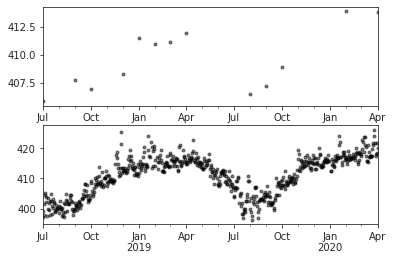

In [ ]:
# Daily plot
fig, axs = plt.subplots(nrows=2)
ts_SAT_daily.plot(marker='.', alpha=0.5, color='k', linestyle='None', figsize=(5,5), subplots=True, ax=axs[0])
ts_ICOS_daily.plot(marker='.', alpha=0.5, color='k', linestyle='None', figsize=(5,5), subplots=True, ax=axs[1])

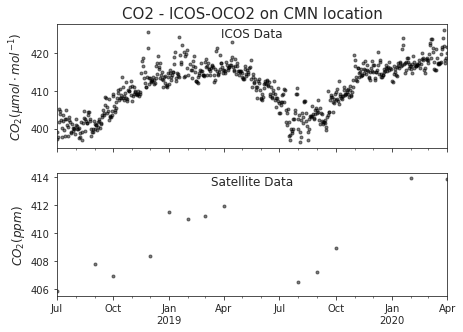

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
# fig.set_title('CO - PUY')
fig.set_figwidth(7)
fig.set_figheight(5)
ax1.set_title('CO2 - ICOS-OCO2 on CMN location', fontsize=15)
# ax1.set_title('ICOS Data')
# ax2.set_title('Satellite Data')
ax1.text(.5,.9,'ICOS Data',
        horizontalalignment='center',
        transform=ax1.transAxes,
        fontsize=12)
ax1.set_ylabel(r'$CO_2 (\mu mol\cdot mol^{-1})$', fontsize=12)
ax2.text(.5,.9,'Satellite Data',
        horizontalalignment='center',
        transform=ax2.transAxes,
        fontsize=12)
ax2.set_ylabel(r'$CO_2 (ppm)$', fontsize=12)

ts_ICOS_daily.plot(marker='.', alpha=0.5, color='k', linestyle='None', ax=ax1)
ts_SAT_daily.plot(marker='.', alpha=0.5, color='k', linestyle='None', ax=ax2)
plt.savefig('CO2-CMN.pdf', format='pdf')

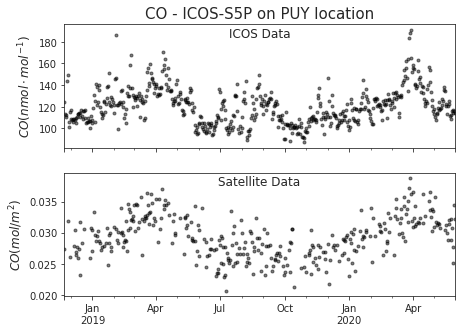

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
# fig.set_title('CO - PUY')
fig.set_figwidth(7)
fig.set_figheight(5)
ax1.set_title('CO - ICOS-S5P on PUY location', fontsize=15)
# ax1.set_title('ICOS Data')
# ax2.set_title('Satellite Data')
ax1.text(.5,.9,'ICOS Data',
        horizontalalignment='center',
        transform=ax1.transAxes,
        fontsize=12)
ax1.set_ylabel(r'$CO (nmol\cdot mol^{-1})$', fontsize=12)
ax2.text(.5,.9,'Satellite Data',
        horizontalalignment='center',
        transform=ax2.transAxes,
        fontsize=12)
ax2.set_ylabel(r'$CO (mol/m^2)$', fontsize=12)

ts_ICOS_daily.plot(marker='.', alpha=0.5, color='k', linestyle='None', ax=ax1)
ts_SAT_daily.plot(marker='.', alpha=0.5, color='k', linestyle='None', ax=ax2)
plt.savefig('CO-PUY.pdf', format='pdf')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb81ad54a50>],
      dtype=object)

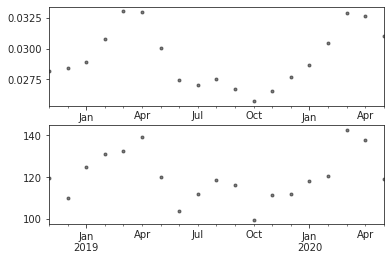

In [ ]:
# Monthly plot
fig, axs = plt.subplots(nrows=2)
ts_SAT_monthly.plot(marker='.', alpha=0.5, color='k', linestyle='None', figsize=(5,5), subplots=True, ax=axs[0])
ts_ICOS_monthly.plot(marker='.', alpha=0.5, color='k', linestyle='None', figsize=(5,5), subplots=True, ax=axs[1])

In [ ]:
# Compute the correlation (without removing the NULL data)
print('Monthly Corr: ' + str(ts_SAT_monthly.corr(ts_ICOS_monthly)))
print('Daily Corr: ' + str(ts_SAT_daily.corr(ts_ICOS_daily)))

Monthly Corr: 0.8935882675899651
Daily Corr: 0.5673552323533361


Corr concated: [[1.0 0.8611643790410002]
 [0.8611643790410002 1.0]]
Corr concated: [[1.0 0.8611643790410001]
 [0.8611643790410001 1.0]]



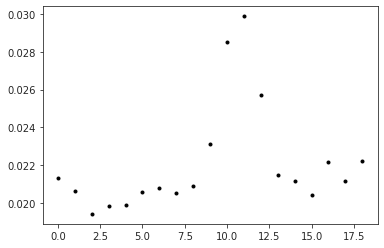

In [ ]:
# Correlation using the CORRCOEF (it supports NaN values in a numpy array)
from scipy.stats.stats import pearsonr  
import numpy as np 
from numpy import ma
np_SAT_monthly = ts_SAT_monthly.values
np_ICOS_monthly = ts_ICOS_monthly.values
print("Corr concated: " + str(ma.corrcoef(ma.masked_invalid(np_SAT_monthly), ma.masked_invalid(np_ICOS_monthly))))

np_SAT_2 = np.concatenate((np_SAT_monthly, np_SAT_monthly))
np_ICOS_2 = np.concatenate((np_ICOS_monthly, np_ICOS_monthly))
print("Corr concated: " + str(ma.corrcoef(ma.masked_invalid(np_SAT_2), ma.masked_invalid(np_ICOS_2))) + "\n")

# 2 series plot
fig, axs = plt.subplots(nrows=1)
plt.plot(np_SAT_monthly, marker='.', alpha=1, color='k', linestyle='None')

In [ ]:
# Demonstration of the pairwise correlation excluding NaN by default of pandas
# We delete NaN from the list
ts_ICOS_monthly_notna = ts_ICOS_monthly[(ts_ICOS_monthly.notna() == True)]
ts_SAT_monthly_notna = ts_SAT_monthly[(ts_SAT_monthly.notna() == True)]
ts_index_monthly_notna = ts_SAT_monthly_notna.index.intersection(ts_ICOS_monthly_notna.index)
ts_ICOS_monthly_notna = ts_ICOS_monthly_notna.get(ts_index_monthly_notna)
ts_SAT_monthly_notna = ts_SAT_monthly_notna.get(ts_index_monthly_notna)

np_SAT_monthly_notna = ts_SAT_monthly_notna.values
np_ICOS_monthly_notna = ts_ICOS_monthly_notna.values
from scipy.stats.stats import pearsonr   
print("Monthly Corr: " + str(pearsonr(np_SAT_monthly_notna, np_ICOS_monthly_notna)))

Monthly Corr: (0.8611643790410002, 2.1979208392279608e-06)
